In [271]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [272]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy as sp
from scipy import signal
import os
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import regionmask

In [273]:
# first load your data

dirn = '/global/scratch/medhap02/ISMData/'
filen = 'GHCN_monthyv4p01.nc'
datgpcp = xr.open_mfdataset(dirn+filen,combine='by_coords')
# precip units are mm/day:
prgpcp = datgpcp['precip']

# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1900-01-01','2014-12-31'))

In [274]:
# take summer mean:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcp.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")
print(prgpcpSeas.dims)

# rechunk data for efficiency:
prgpcpSeas.data = prgpcpSeas.data.rechunk(-1)

# eliminate any NaNs:
#prgpcpSeas = prgpcpSeas.ffill('lon').bfill('lon').ffill('lat').bfill('lat')
prgpcpSeas.load()

('year', 'lat', 'lon')


/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'precip' (year: 115, lat: 360, lon: 720)>
array([[[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [1.285 , 1.285 , ..., 1.2825, 1.2825],
        [1.29  , 1.29  , ..., 1.2925, 1.29  ]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [0.33  , 0.33  , ..., 0.33  , 0.33  ],
        [0.33  , 0.33  , ..., 0.33  , 0.33  ]],

       ...,

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [0.    , 0.    , ..., 0.    , 0.    ],
        [0.    , 0.    , ..., 0.    , 0.    ]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ...,
        [0.    , 0.    , ..., 0.    , 0.    ],
        [0.    , 0.    , ..., 0.    , 0.    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon    

In [275]:
latlim1 = 90
latlim2 = -90

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_prfull = Eof(tmppr,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [276]:
print(coslat2)
print(tmppr)

<xarray.DataArray 'lat' (year: 115, lat: 360, lon: 720)>
array([[[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       ...,

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.0

In [350]:
#(5-35n, 65-95e)
latlim1 = 35
latlim2 = 5
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr = Eof(tmppr,weights=coslat2,center=True)
pcs_pr = solver_pr.pcs()
eofs_pr = solver_pr.eofs()
varfrac_pr = solver_pr.varianceFraction()

In [278]:
tmpprtrimmed = tmppr.sel(year=slice('1979-01-01','2015-12-31'))
tmppr2, coslat2 = xr.broadcast(tmpprtrimmed, coslat)

solver_pr_trimmed = Eof(tmpprtrimmed,weights=coslat2,center=True)
pcs_pr_trimmed = solver_pr_trimmed.pcs()
eofs_pr_trimmed = solver_pr_trimmed.eofs()
varfrac_pr_trimmed = solver_pr_trimmed.varianceFraction()

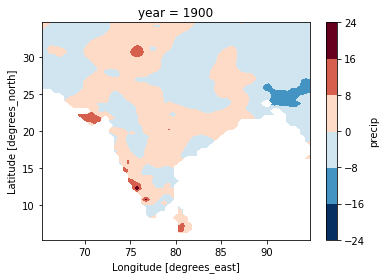

In [279]:
tmppr[0,:,:].plot.contourf()

In [353]:
# take seasonal mean and select latitudes to use in analysis:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(prgpcpSeas)
India_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("India")
precip_India = prgpcpSeas.where(mask == India_index)

# subtract time mean from each data point (EOFs work with anomalies)
precip_India = precip_India - precip_India.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
precip_India.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(precip_India.lat*np.pi/180)
precip_India2, coslat2 = xr.broadcast(precip_India, coslat)

# find the EOFs
India_solver_pr = Eof(precip_India,weights=coslat2,center=True)
India_pcs_pr = India_solver_pr.pcs()
India_eofs_pr = India_solver_pr.eofs()
India_varfrac_pr = India_solver_pr.varianceFraction()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [341]:
precip_India_trimmed = precip_India.sel(year=slice('1979-01-01','2015-12-31'))
precip_India2, coslat2 = xr.broadcast(precip_India_trimmed, coslat)

India_solver_pr_trimmed = Eof(precip_India_trimmed,weights=coslat2,center=True)
India_pcs_pr_trimmed = India_solver_pr_trimmed.pcs()
India_eofs_pr_trimmed = India_solver_pr_trimmed.eofs()
India_varfrac_pr_trimmed = India_solver_pr_trimmed.varianceFraction()

# plot results

sum of variance in first 4 pr EOFs =  0.21559002
total anomaly variance pr = 260969.36


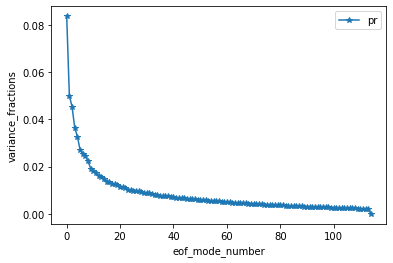

In [282]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

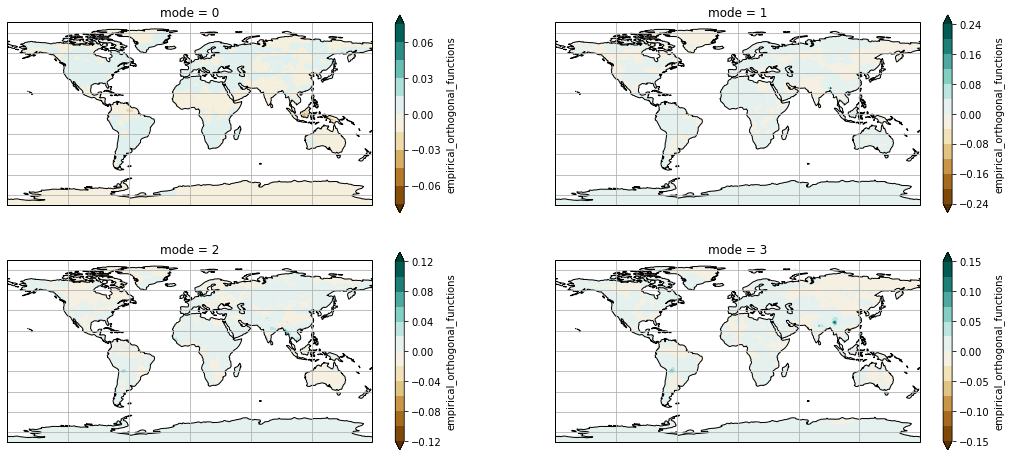

In [283]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

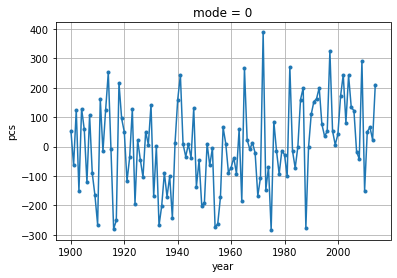

In [284]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

sum of variance in first 4 pr EOFs =  0.40508002
total anomaly variance pr = 56902.047


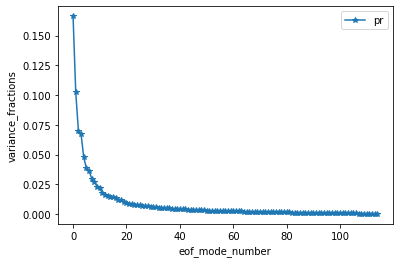

In [285]:
varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr.totalAnomalyVariance())

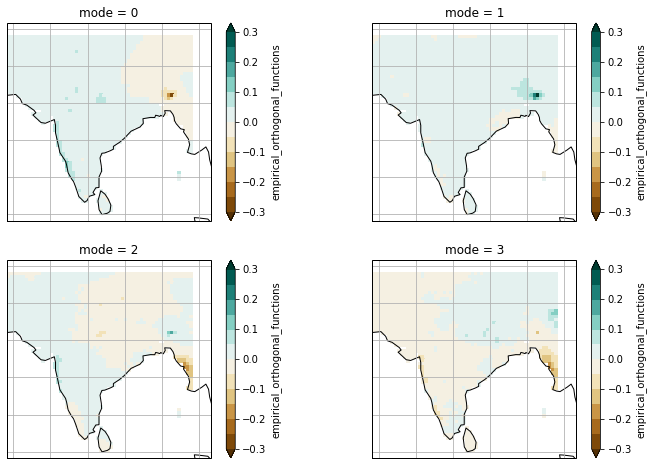

In [328]:
levels=np.linspace(-0.30, .30, 13)
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr[i,:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

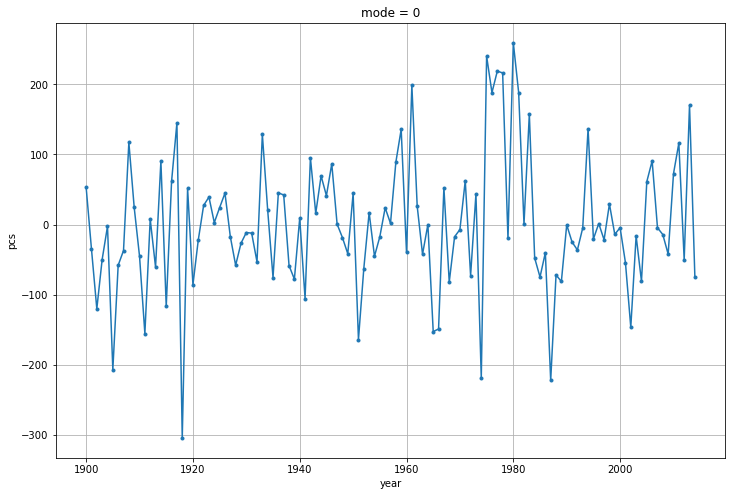

In [287]:
levels=np.linspace(-90, 90, 13)
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=0).plot(marker='.')
plt.grid()

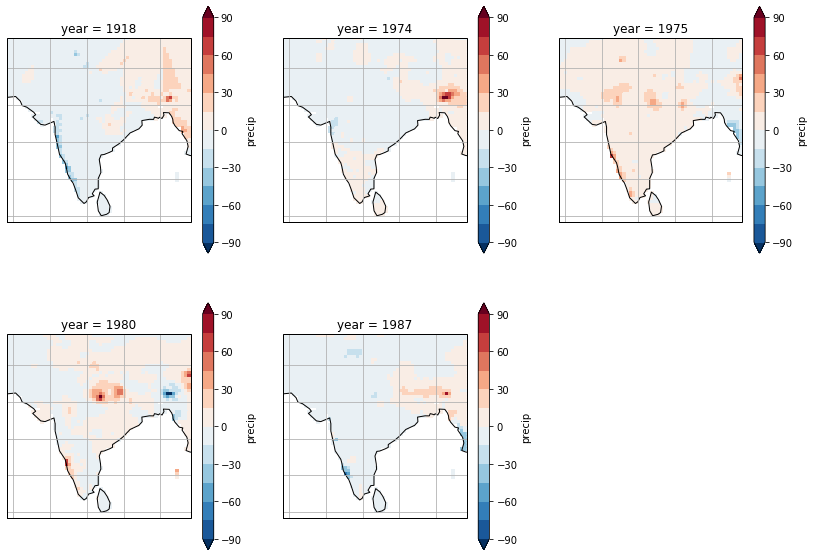

In [288]:
pcs_pr.sel(mode=0)
mode0 = [18, 74, 75, 80, 87]
plt.figure(figsize=(14,10))
for i in np.arange(0,5):
    ax = plt.subplot(2,3,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

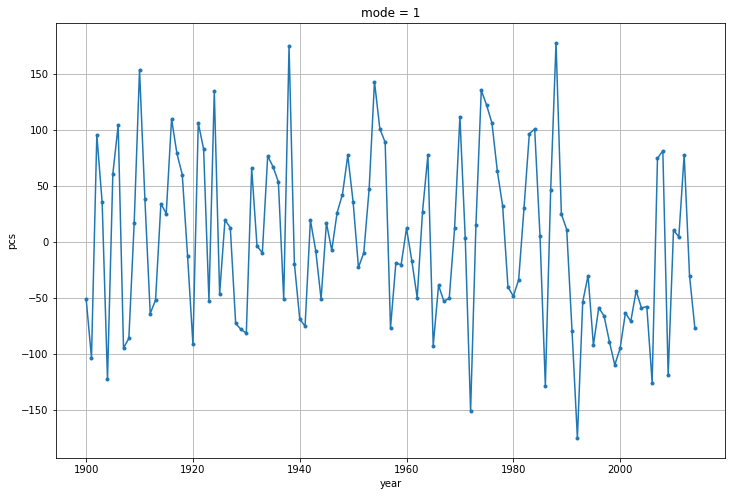

In [289]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=1).plot(marker='.')
plt.grid()

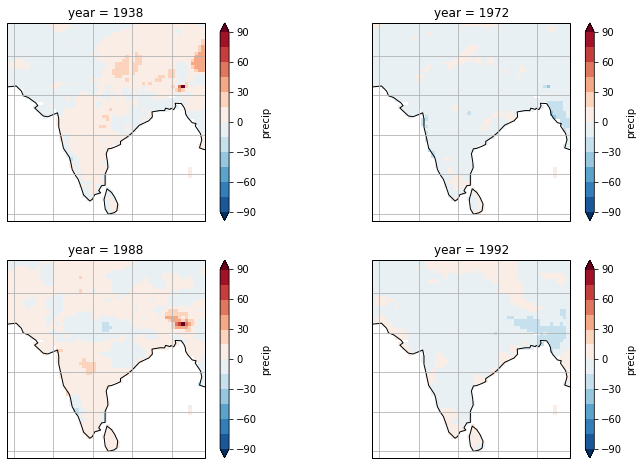

In [290]:
pcs_pr.sel(mode=1)
mode1 = [38, 72, 88, 92]
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

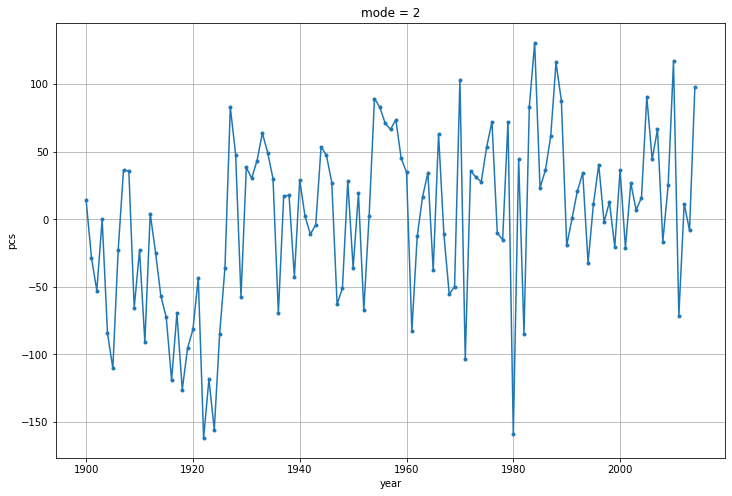

In [291]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=2).plot(marker='.')
plt.grid()

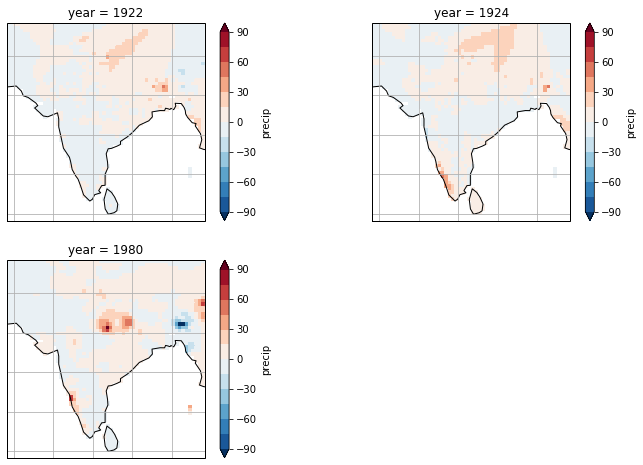

In [292]:
pcs_pr.sel(mode=2)
mode2 = [22, 24, 80]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

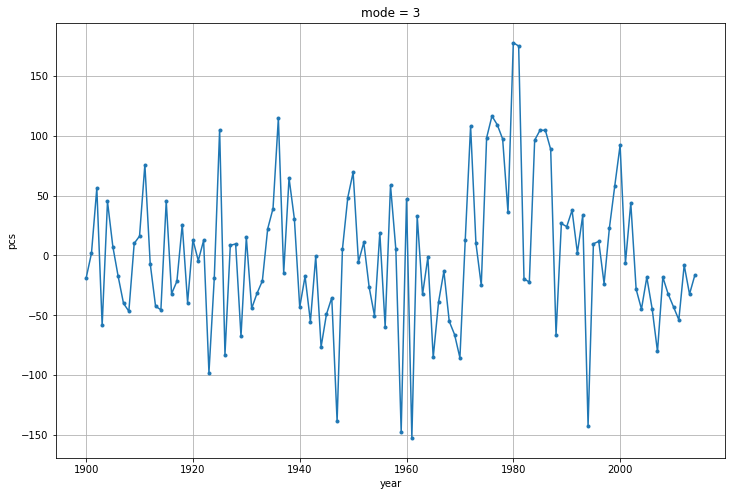

In [293]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=3).plot(marker='.')
plt.grid()

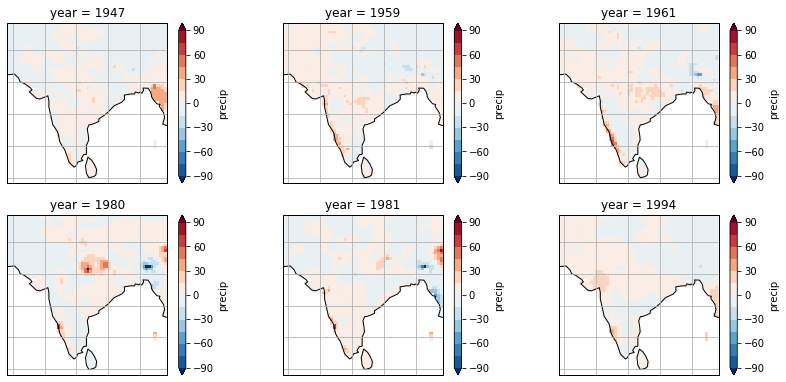

In [294]:
pcs_pr.sel(mode=0)
mode0 = [47, 59, 61, 80, 81, 94]
plt.figure(figsize=(14,10))
for i in np.arange(0,6):
    ax = plt.subplot(3,3,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

sum of variance in first 4 pr EOFs =  0.59923553
total anomaly variance pr = 49621.367


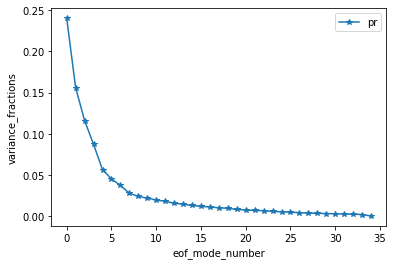

In [295]:
varfrac_pr_trimmed.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr_trimmed[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr_trimmed.totalAnomalyVariance())

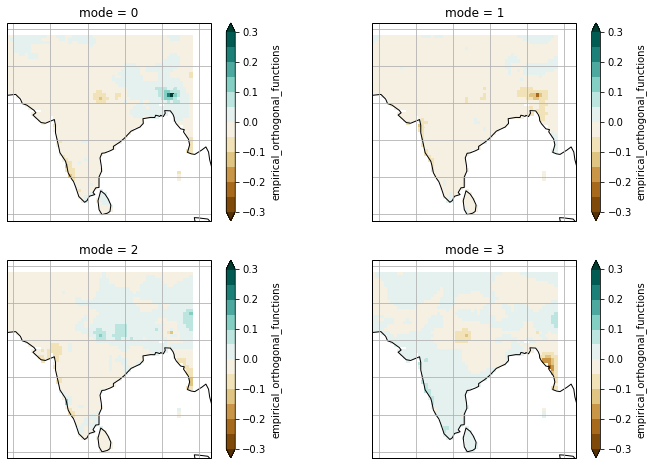

In [364]:
levels=np.linspace(-0.3, .3, 13)
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr_trimmed[i,:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

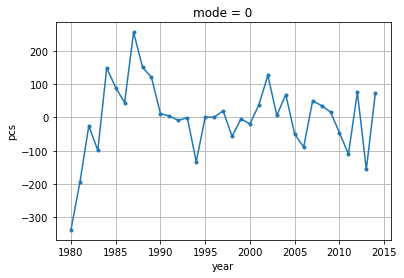

In [297]:
levels=np.linspace(-90, 90, 13)
pcs_pr_trimmed.sel(mode=0).plot(marker='.')
plt.grid()

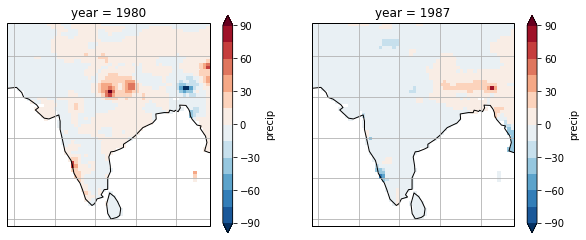

In [298]:
pcs_pr.sel(mode=0)
mode0 = [0, 7]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

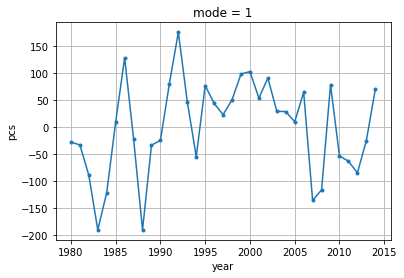

In [299]:
pcs_pr_trimmed.sel(mode=1).plot(marker='.')
plt.grid()

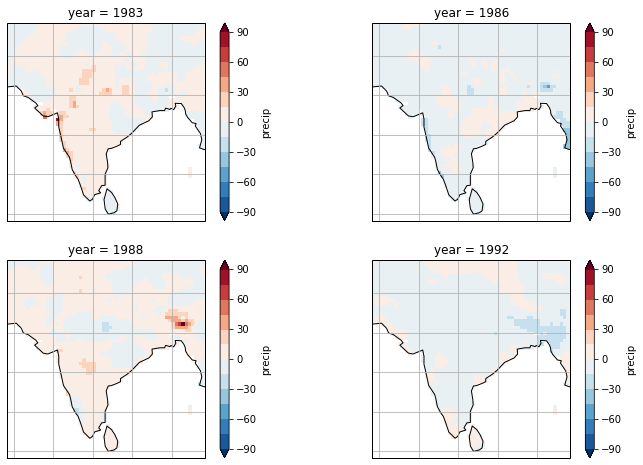

In [300]:
pcs_pr.sel(mode=1)
mode1 = [3, 6, 8, 12]
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

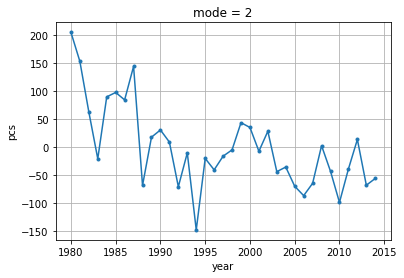

In [301]:
pcs_pr_trimmed.sel(mode=2).plot(marker='.')
plt.grid()

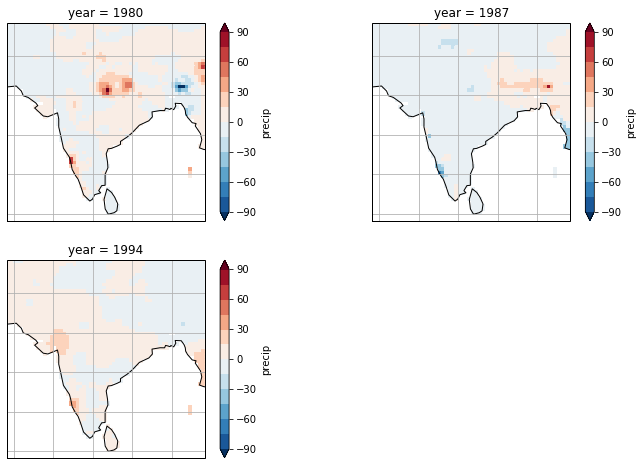

In [302]:
pcs_pr.sel(mode=2)
mode2 = [0, 7, 14]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

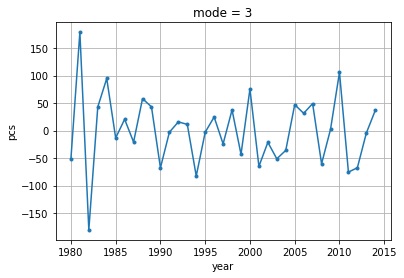

In [303]:
pcs_pr_trimmed.sel(mode=3).plot(marker='.')
plt.grid()

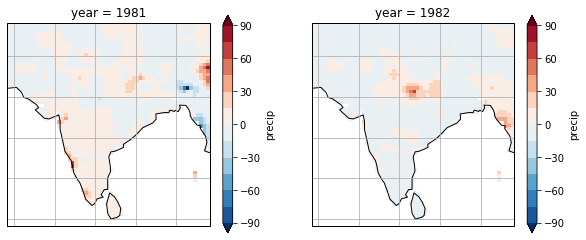

In [304]:
pcs_pr.sel(mode=3)
mode3 = [1, 2]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode3[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

# correlation with AIRI

In [305]:
dirn = '/global/scratch/medhap02/ISMData/'
filen = 'pALLIN.nc'
airi_dat = xr.open_dataset(dirn+filen, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
precip = airi_dat['precip']

precipfull = precip.sel(time=slice('1900-01-01','2014-12-31'))

In [306]:
def is_summer(month):
    return (month >= 6) & (month <= 9)
precip_subset = precipfull.sel(time=is_summer(precipfull['time.month']))#.groupby('time.year').mean()


precip_subset = precip_subset.groupby('time.year',restore_coord_dims = True).sum("time")
#print(precip_subset.dims)

#print(precip_subset)

precip_jjas = precip_subset - precip_subset.mean(dim='year')

print(precip_jjas)

<xarray.DataArray 'precip' (year: 115)>
array([ -34.645264,  -91.845215, -104.94519 ,   -6.045227,  -34.645203,
       -138.1452  ,   16.55481 ,  -23.74524 ,   51.354797,   53.05481 ,
         40.454773, -126.345215,   -6.845215,   10.154785,   51.25476 ,
        -64.64526 ,   67.75482 ,   80.454834,  -94.04523 ,   55.25476 ,
        -84.94519 ,  -27.845215,  -16.145203,  -36.545227,  -51.045227,
         39.454773,   17.154785,   19.054749,  -50.74524 ,    9.454773,
        -42.145203,    2.954773,  -31.94519 ,  143.45477 ,   47.954773,
        -40.145203,   75.05481 ,   -7.245239,   85.75476 ,  -61.74524 ,
         81.8548  ,  -74.1452  ,   92.25476 ,   13.254822,   93.25476 ,
         11.354797,   91.75482 ,   21.75476 ,   28.554749,   23.854797,
         10.05481 ,  -63.345215,   12.354797,   52.354736,  -38.345215,
         46.05481 ,  162.8548  ,  -10.44519 ,    7.954834,   59.654785,
          2.154785,  117.05481 ,  -67.6452  ,   14.854736,   36.75476 ,
       -126.04523 ,  -73

In [307]:
precip_jjas_trimmed = precip_jjas.sel(year=slice('1980','2014'))
precip_jjas_trimmed

<xarray.DataArray 'precip' (year: 35)>
array([  63.55481 ,  -15.145203,  -62.545227,   32.454834,    5.854797,
        -71.14526 ,  -54.345215, -122.94519 ,   78.8548  ,   16.05481 ,
         99.05481 ,   12.854797,  -13.645264,  -38.645264,  120.454834,
          1.154785,    8.954773,    0.654785,  -37.845215,  -15.645203,
         13.05481 ,   11.654785, -153.1452  ,  -19.045227,  -26.845215,
        -56.845215,   88.25476 ,   49.854797,   27.55481 , -123.845215,
         21.154785,   28.354736,  -79.845215,  114.95477 ,  -96.345215],
      dtype=float32)
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2010 2011 2012 2013 2014

In [308]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [309]:
pcs_pr_trimmed.sel(mode=0)

<xarray.DataArray 'pcs' (year: 35)>
array([-337.93265 , -195.42801 ,  -24.904408,  -99.2269  ,  148.29054 ,
         89.65815 ,   44.51478 ,  255.7585  ,  151.00485 ,  119.97727 ,
         11.483853,    4.108143,   -8.989834,   -0.579407, -132.79976 ,
          0.582258,    0.627415,   19.583914,  -56.38788 ,   -4.56931 ,
        -19.514114,   37.78916 ,  126.18921 ,    5.908669,   68.42455 ,
        -50.404694,  -88.95721 ,   49.179134,   35.709736,   16.056295,
        -46.18878 , -109.97635 ,   75.4631  , -156.31255 ,   71.862305],
      dtype=float32)
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2010 2011 2012 2013 2014
    mode     int64 0

In [310]:
corr0 = correlation(pcs_pr_trimmed.sel(mode=0), precip_jjas_trimmed, dims='year')
#corr.plot.contourf(extend='both')
corr1 = correlation(pcs_pr_trimmed.sel(mode=1), precip_jjas_trimmed, dims='year')
corr2 = correlation(pcs_pr_trimmed.sel(mode=2), precip_jjas_trimmed, dims='year')
corr3 = correlation(pcs_pr_trimmed.sel(mode=3), precip_jjas_trimmed, dims='year')
print("GHNC (1980 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

GHNC (1980 - 2014)
mode 0:  -0.4772666827551617
mode 1:  -0.36088955059436206
mode 2:  -0.304796793384957
mode 3:  0.030741454528387602


In [311]:
corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas, dims='year')
print("GHNC (1900 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

GHNC (1900 - 2014)
mode 0:  0.6644148789648402
mode 1:  0.27154291615692083
mode 2:  0.060476104881147255
mode 3:  -0.22398737512772923


# regionmask India

sum of variance in first 4 pr EOFs =  0.48974183
total anomaly variance pr = 41179.918


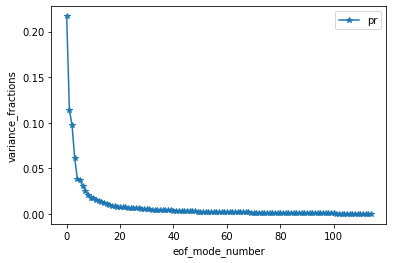

In [312]:
India_varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', India_varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', India_solver_pr.totalAnomalyVariance())

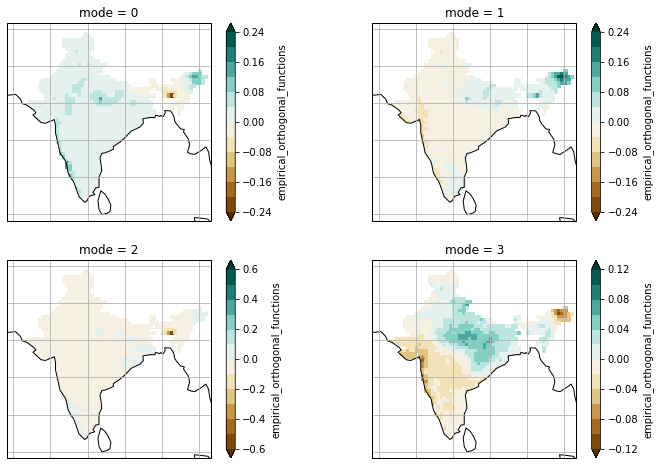

In [329]:
levels=np.linspace(-0.30, .30, 13)
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    India_eofs_pr[i,:,:].plot.pcolormesh(ax=ax,levels=13,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

In [314]:
corr0 = correlation(India_pcs_pr.sel(mode=0), precip_jjas, dims='year')
corr1 = correlation(India_pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(India_pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(India_pcs_pr.sel(mode=3), precip_jjas, dims='year')

print("India GHNC (1900 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

India GHNC (1900 - 2014)
mode 0:  0.5953833204977491
mode 1:  -0.4127303109836999
mode 2:  -0.27030978411239953
mode 3:  0.11090060432499224


sum of variance in first 4 pr EOFs =  0.67563355
total anomaly variance pr = 42008.016


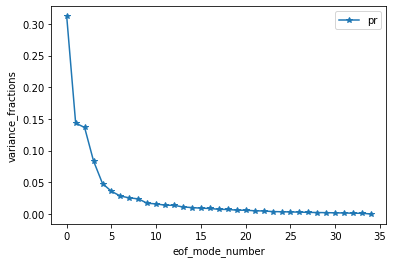

In [315]:
India_varfrac_pr_trimmed.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', India_varfrac_pr_trimmed[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', India_solver_pr_trimmed.totalAnomalyVariance())

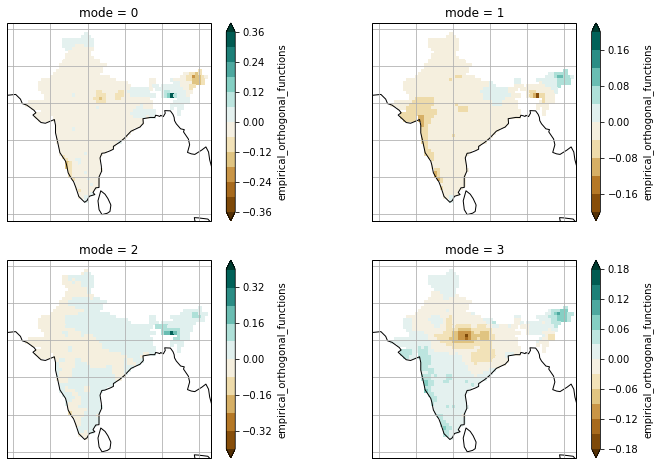

In [366]:
levels=np.linspace(-0.3, .3, 13)
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    India_eofs_pr_trimmed[i,:,:].plot.pcolormesh(ax=ax,levels=13,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

In [317]:
corr0 = correlation(India_pcs_pr_trimmed.sel(mode=0), precip_jjas_trimmed, dims='year')
corr1 = correlation(India_pcs_pr_trimmed.sel(mode=1), precip_jjas_trimmed, dims='year')
corr2 = correlation(India_pcs_pr_trimmed.sel(mode=2), precip_jjas_trimmed, dims='year')
corr3 = correlation(India_pcs_pr_trimmed.sel(mode=3), precip_jjas_trimmed, dims='year')

print("India GHNC (1980 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

India GHNC (1980 - 2014)
mode 0:  -0.35588693928322107
mode 1:  -0.5771840823365698
mode 2:  -0.14550221155718948
mode 3:  -0.02183453299949216


# west of bangladesh

In [318]:
#[65,89,8,35]
latlim1 = 35
latlim2 = 8
lonlim1 = 65
lonlim2 = 89

# take seasonal mean and select latitudes to use in analysis:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(prgpcpSeas)
WestofBangladesh_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("India")
precip_WestofBangladesh = prgpcpSeas.where(mask == WestofBangladesh_index)
precip_WestofBangladesh = precip_WestofBangladesh.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

# subtract time mean from each data point (EOFs work with anomalies)
precip_WestofBangladesh = precip_WestofBangladesh - precip_WestofBangladesh.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
precip_WestofBangladesh.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(precip_WestofBangladesh.lat*np.pi/180)
precip_WestofBangladesh2, coslat2 = xr.broadcast(precip_WestofBangladesh, coslat)

# find the EOFs
solver_pr_WestofBangladesh = Eof(precip_WestofBangladesh,weights=coslat2,center=True)
pcs_pr_WestofBangladesh = solver_pr_WestofBangladesh.pcs()
eofs_pr_WestofBangladesh = solver_pr_WestofBangladesh.eofs()
varfrac_pr_WestofBangladesh = solver_pr_WestofBangladesh.varianceFraction()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [319]:
precip_WestofBangladesh_trimmed = precip_WestofBangladesh.sel(year=slice('1979-01-01','2015-12-31'))
precip_WestofBangladesh2, coslat2 = xr.broadcast(precip_WestofBangladesh_trimmed, coslat)

WestofBangladesh_solver_pr_trimmed = Eof(precip_WestofBangladesh_trimmed,weights=coslat2,center=True)
WestofBangladesh_pcs_pr_trimmed = WestofBangladesh_solver_pr_trimmed.pcs()
WestofBangladesh_eofs_pr_trimmed = WestofBangladesh_solver_pr_trimmed.eofs()
WestofBangladesh_varfrac_pr_trimmed = WestofBangladesh_solver_pr_trimmed.varianceFraction()

sum of variance in first 4 pr EOFs =  0.45893216
total anomaly variance pr = 29798.348


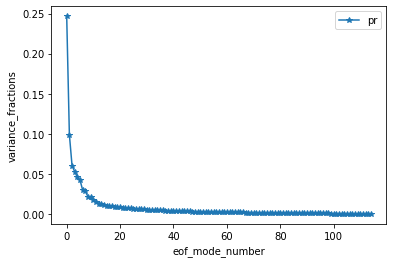

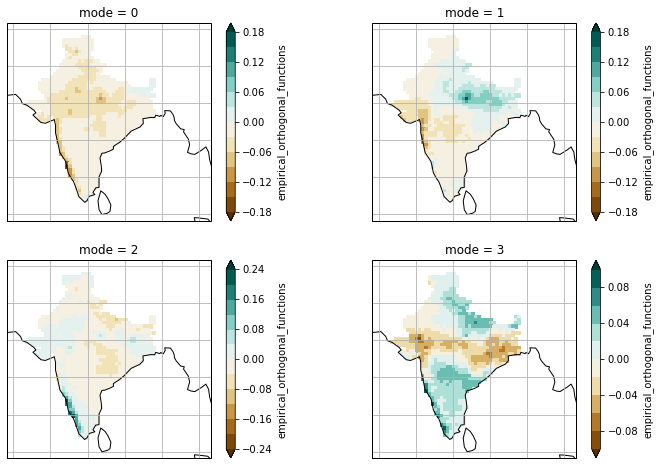

In [330]:
varfrac_pr_WestofBangladesh.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr_WestofBangladesh[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr_WestofBangladesh.totalAnomalyVariance())

plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr_WestofBangladesh[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

sum of variance in first 4 pr EOFs =  0.60558707
total anomaly variance pr = 29798.348


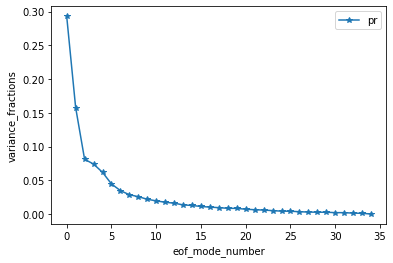

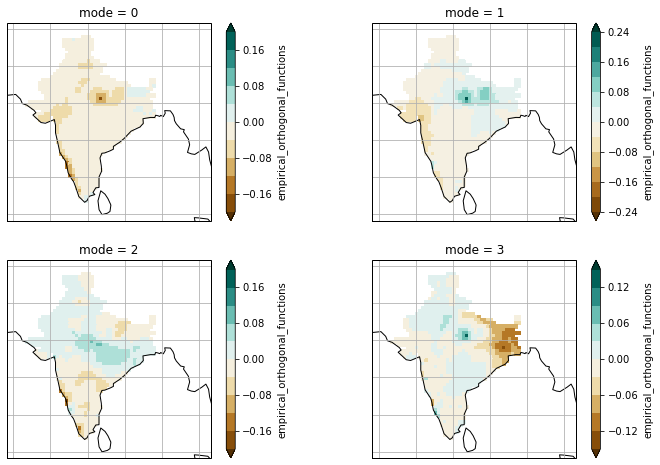

In [367]:
WestofBangladesh_varfrac_pr_trimmed.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', WestofBangladesh_varfrac_pr_trimmed[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr_WestofBangladesh.totalAnomalyVariance())

plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    WestofBangladesh_eofs_pr_trimmed[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,98,5,37],crs=ccrs.PlateCarree())

In [322]:
pcs_pr = pcs_pr_WestofBangladesh#.sel(year=slice('1980', '2016'))

corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas, dims='year')
print("West of Bangladesh GHNC (1900 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

West of Bangladesh GHNC (1900 - 2014)
mode 0:  -0.7319657283550692
mode 1:  -0.13589026049940825
mode 2:  -0.23064343847291333
mode 3:  -0.13451315228749144


In [365]:
pcs_pr = pcs_pr_WestofBangladesh.sel(year=slice('1980', '2014'))

corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas_trimmed, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas_trimmed, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas_trimmed, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas_trimmed, dims='year')
print("West of Bangladesh (1980 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

West of Bangladesh (1980 - 2014)
mode 0:  -0.6640050987301703
mode 1:  -0.155437441922791
mode 2:  -0.03806235350224593
mode 3:  -0.01781476839317798


# correlation plots

In [358]:
levels=np.linspace(-.75, .75, 7)

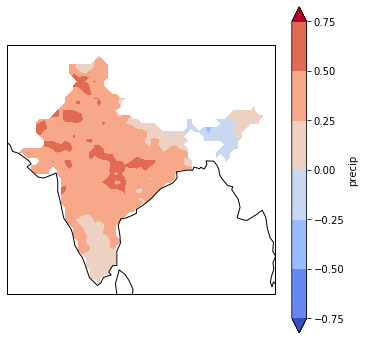

In [359]:
#precip_India = precip_India.sel(year=slice('1980', '2016'))

plt.figure(figsize=(6,6))
India_correlation = correlation(precip_India,precip_jjas,dims='year')
ax = plt.axes(projection=ccrs.PlateCarree())
India_correlation.plot.contourf(cmap='coolwarm', levels=levels, extend='both')
ax.coastlines()

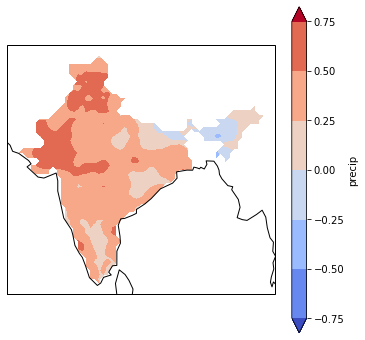

In [360]:
#precip_Indiatrimmed = precip_India.sel(year=slice('1980', '2014'))

plt.figure(figsize=(6,6))
India_correlation = correlation(precip_India_trimmed,precip_jjas_trimmed,dims='year')
ax = plt.axes(projection=ccrs.PlateCarree())
India_correlation.plot.contourf(cmap='coolwarm', levels=levels, extend='both')
ax.coastlines()

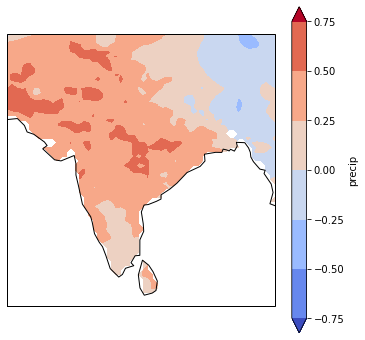

In [362]:
plt.figure(figsize=(6,6))
India_correlation = correlation(tmppr,precip_jjas,dims='year')
ax = plt.axes(projection=ccrs.PlateCarree())
India_correlation.plot.contourf(cmap='coolwarm', levels=levels, extend='both')
ax.coastlines()

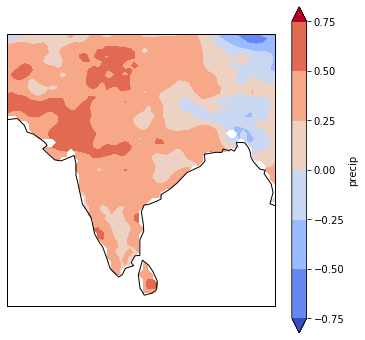

In [363]:
plt.figure(figsize=(6,6))
India_correlation = correlation(tmpprtrimmed,precip_jjas_trimmed,dims='year')
ax = plt.axes(projection=ccrs.PlateCarree())
India_correlation.plot.contourf(cmap='coolwarm', levels=levels, extend='both')
ax.coastlines()

In [338]:
 # Copyright (c) 2020 Medha Palavalli.